In [1]:
!nvidia-smi

Thu Feb 29 23:13:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P5              24W / 215W |    498MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [7]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [8]:
np.unique(y_test)

array(['anger', 'hapiness', 'neutral', 'sadness'], dtype='<U8')

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']

In [10]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback

In [12]:
from IConNet.nn.model import M13sinc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m14sinc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M14sinc', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': True, 'learnable_windows': False, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                            | 0.00028571428571428574/10 [00:00<5:20:04, 1920.48s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.404284
Mem before-during-after: 1692160 2337387520 26915328


  0%|                               | 0.011999999999999992/10 [00:12<2:42:41, 977.30s/it]

Train Epoch: 1 [320/22400 (1%)]	Loss: 1.681274
Mem before-during-after: 26915328 2451376128 26915328


  0%|                              | 0.023142857142857107/10 [00:23<2:47:18, 1006.17s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.453124
Mem before-during-after: 26915328 2325933568 27436544


  0%|                               | 0.034857142857142795/10 [00:34<2:28:38, 894.93s/it]

Train Epoch: 1 [960/22400 (4%)]	Loss: 1.530120
Mem before-during-after: 26915328 2662397440 26915328


  0%|▏                              | 0.046285714285714194/10 [00:44<2:28:05, 892.69s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.176106
Mem before-during-after: 26915328 2661644288 26915328


  1%|▏                               | 0.05771428571428559/10 [00:55<2:29:15, 900.72s/it]

Train Epoch: 1 [1600/22400 (7%)]	Loss: 1.078787
Mem before-during-after: 26915328 2535453184 26915328


  1%|▏                              | 0.06885714285714287/10 [01:06<2:50:06, 1027.68s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.174230
Mem before-during-after: 26915328 2663412224 26915328


  1%|▏                              | 0.08028571428571454/10 [01:17<2:57:03, 1070.98s/it]

Train Epoch: 1 [2240/22400 (10%)]	Loss: 1.237088
Mem before-during-after: 26915328 2599262720 26915328


  1%|▎                               | 0.09200000000000051/10 [01:28<2:30:17, 910.16s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.823777
Mem before-during-after: 26915328 2662397440 26915328


  1%|▎                               | 0.10342857142857219/10 [01:38<2:32:12, 922.75s/it]

Train Epoch: 1 [2880/22400 (13%)]	Loss: 1.326361
Mem before-during-after: 26915328 2662397440 26915328


  1%|▎                              | 0.11457142857142957/10 [01:49<2:45:27, 1004.29s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.251590
Mem before-during-after: 26915328 2663221760 26915328


  1%|▍                               | 0.12628571428571547/10 [01:59<2:31:08, 918.46s/it]

Train Epoch: 1 [3520/22400 (16%)]	Loss: 1.383784
Mem before-during-after: 26915328 2663221760 26915328


  1%|▍                                | 0.1377142857142866/10 [02:10<2:31:30, 921.78s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.084696
Mem before-during-after: 26915328 2411262464 26915328


  1%|▍                              | 0.14885714285714344/10 [02:21<2:45:27, 1007.80s/it]

Train Epoch: 1 [4160/22400 (19%)]	Loss: 1.463202
Mem before-during-after: 26915328 2663221760 26915328


  2%|▌                               | 0.16057142857142884/10 [02:32<2:30:47, 919.50s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.368962
Mem before-during-after: 26915328 2661644288 26915328


  2%|▌                              | 0.17171428571428568/10 [02:42<2:44:05, 1001.80s/it]

Train Epoch: 1 [4800/22400 (21%)]	Loss: 1.366850
Mem before-during-after: 26915328 2662397440 26915328


  2%|▌                               | 0.18342857142857108/10 [02:53<2:29:22, 913.02s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.432134
Mem before-during-after: 26915328 2537010176 26915328


  2%|▋                                | 0.1948571428571422/10 [03:04<2:27:09, 900.51s/it]

Train Epoch: 1 [5440/22400 (24%)]	Loss: 1.211035
Mem before-during-after: 26915328 2200761856 26915328


  2%|▋                              | 0.20599999999999904/10 [03:14<2:46:44, 1021.48s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.563270
Mem before-during-after: 26915328 2662067200 26915328


  2%|▋                               | 0.21771428571428444/10 [03:25<2:29:18, 915.80s/it]

Train Epoch: 1 [6080/22400 (27%)]	Loss: 1.109116
Mem before-during-after: 26915328 2661644288 26915328


  2%|▋                               | 0.22914285714285557/10 [03:36<2:30:25, 923.76s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.150798
Mem before-during-after: 26915328 2662523904 26915328


  2%|▊                                | 0.2405714285714267/10 [03:46<2:29:29, 919.10s/it]

Train Epoch: 1 [6720/22400 (30%)]	Loss: 1.319817
Mem before-during-after: 26915328 2495394304 26915328


  3%|▊                               | 0.25199999999999784/10 [03:56<2:26:10, 899.68s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.181756
Mem before-during-after: 26915328 2663221760 26915328


  3%|▊                               | 0.26342857142856896/10 [04:07<2:24:43, 891.82s/it]

Train Epoch: 1 [7360/22400 (33%)]	Loss: 1.538510
Mem before-during-after: 26915328 2095663104 26915328


  3%|▉                                | 0.2745714285714258/10 [04:17<2:40:34, 990.62s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.869830
Mem before-during-after: 26915328 2661644288 26915328


  3%|▉                                | 0.2862857142857112/10 [04:28<2:23:27, 886.08s/it]

Train Epoch: 1 [8000/22400 (36%)]	Loss: 1.307240
Mem before-during-after: 26915328 2663221760 26915328


  3%|▉                                | 0.2977142857142823/10 [04:38<2:24:26, 893.22s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.233902
Mem before-during-after: 26915328 2662067200 26915328


  3%|▉                               | 0.30914285714285344/10 [04:48<2:24:54, 897.19s/it]

Train Epoch: 1 [8640/22400 (39%)]	Loss: 1.344503
Mem before-during-after: 26915328 2663221760 26915328


  3%|█                               | 0.32057142857142457/10 [04:59<2:27:49, 916.36s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: nan
Mem before-during-after: 26915328 2662820352 26915328


  3%|█                                | 0.3319999999999957/10 [05:10<2:26:07, 906.87s/it]

Train Epoch: 1 [9280/22400 (41%)]	Loss: nan
Mem before-during-after: 26915328 2661644288 26915328


  3%|█                               | 0.34314285714285253/10 [05:20<2:39:40, 992.10s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: nan
Mem before-during-after: 26915328 2662397440 26915328


  4%|█▏                              | 0.35485714285713793/10 [05:31<2:25:49, 907.17s/it]

Train Epoch: 1 [9920/22400 (44%)]	Loss: nan
Mem before-during-after: 26915328 2663221760 26915328


  4%|█▏                              | 0.36628571428570905/10 [05:41<2:21:59, 884.39s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: nan
Mem before-during-after: 26915328 2663221760 26915328


  4%|█▏                               | 0.3777142857142802/10 [05:51<2:19:34, 870.37s/it]

Train Epoch: 1 [10560/22400 (47%)]	Loss: nan
Mem before-during-after: 26915328 2202882048 26915328


  4%|█▎                               | 0.3891428571428513/10 [06:02<2:25:01, 905.37s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: nan
Mem before-during-after: 26915328 2663221760 26915328


  4%|█▎                               | 0.3914285714285655/10 [06:04<2:29:19, 932.41s/it]

KeyboardInterrupt



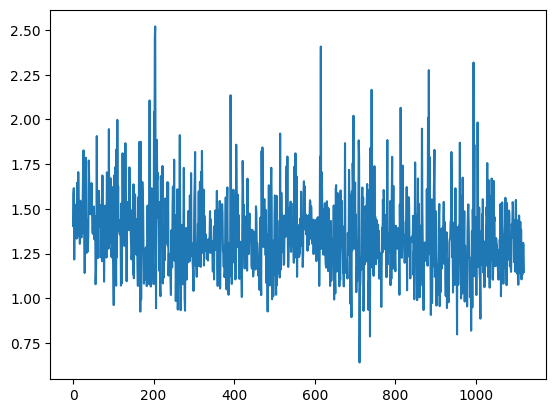

In [16]:
plt.plot(train_losses)

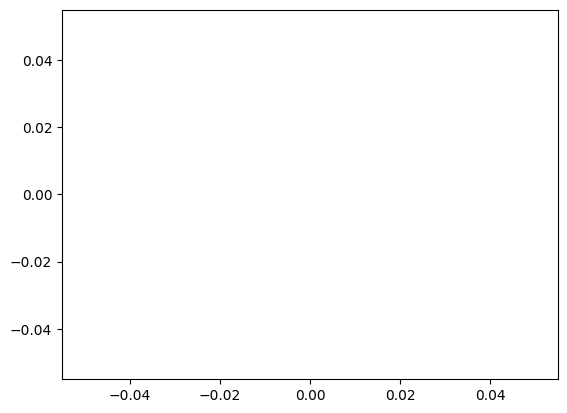

In [17]:
plt.plot(test_accuracy)

In [19]:
# del model
# gc.collect()

693